In [1]:
!nvidia-smi

Sun Jun 20 17:05:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!apt install libcudnn8 --allow-change-held-packages

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8 libcudnn8-dev
2 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,070 MB of archives.
After this operation, 337 MB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8-dev 8.2.1.32-1+cuda11.3 [614 MB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.2.1.32-1+cuda11.3 [456 MB]
Fetched 1,070 MB in 20s (53.8 MB/s)
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../libcudnn8-dev_8.2.1.32-1+cuda11.3_amd64.deb ...
Unpacking libcudnn8-dev (8.2.1.32-1+cuda11.3) over (8.0.4.30-1+cuda11.0) ...
Preparing to unpack .../libcudnn8_8.2.1.3

In [3]:
%pip install -q tensorflow-addons[tensorflow]
%pip install -q simpleitk
# %pip install -q colab_ssh
%pip install -q wandb

     |████████████████████████████████| 686kB 9.7MB/s 
     |████████████████████████████████| 47.4MB 102kB/s 
     |████████████████████████████████| 1.8MB 8.3MB/s 
     |████████████████████████████████| 102kB 9.3MB/s 
     |████████████████████████████████| 133kB 45.6MB/s 
     |████████████████████████████████| 174kB 44.7MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 


In [4]:
!gdown https://drive.google.com/uc?id=1jYb-dKqywLm5bQ5esP6YSV5xuBzqBPqm

Downloading...
From: https://drive.google.com/uc?id=1jYb-dKqywLm5bQ5esP6YSV5xuBzqBPqm
To: /content/BRATS_Dataset.tar.gz
2.76GB [00:22, 125MB/s] 


In [5]:
!apt -qq install pigz

The following NEW packages will be installed:
  pigz
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 57.4 kB of archives.
After this operation, 259 kB of additional disk space will be used.
Selecting previously unselected package pigz.
(Reading database ... 160784 files and directories currently installed.)
Preparing to unpack .../archives/pigz_2.4-1_amd64.deb ...
Unpacking pigz (2.4-1) ...
Setting up pigz (2.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [6]:
!pigz -dc BRATS_Dataset.tar.gz | tar xf -

In [7]:
!rm BRATS_Dataset.tar.gz

In [8]:
%cd /content
!rm -rf 3D_res_attn_Unet

/content


In [9]:
!git clone https://github.com/ShivamShrirao/3D_res_attn_Unet

Cloning into '3D_res_attn_Unet'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (247/247), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 247 (delta 173), reused 154 (delta 80), pack-reused 0
Receiving objects: 100% (247/247), 595.06 KiB | 19.83 MiB/s, done.
Resolving deltas: 100% (173/173), done.


In [10]:
%cd 3D_res_attn_Unet

/content/3D_res_attn_Unet


In [11]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

In [12]:
import SimpleITK as sitk

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import glob
from tqdm.notebook import tqdm
from time import time
import os
%matplotlib inline

In [14]:
# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

In [15]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [16]:
def get_data_paths(dataset_path):
    t1 = glob.glob(dataset_path+'/*GG/*/*t1.nii.gz')
    t2 = glob.glob(dataset_path+'/*GG/*/*t2.nii.gz')
    t1ce = glob.glob(dataset_path+'/*GG/*/*t1ce.nii.gz')
    flair = glob.glob(dataset_path+'/*GG/*/*flair.nii.gz')
    seg = glob.glob(dataset_path+'/*GG/*/*seg.nii.gz')
    return list(zip(t1, t2, t1ce, flair, seg))

In [17]:
train_paths = get_data_paths('../BRATS_Dataset/brats_dataset/')
val_paths = get_data_paths('../BRATS_Dataset/brats_test_dataset/')

In [18]:
len(train_paths), len(val_paths)

(285, 50)

In [19]:
from model.preprocess_brats import *

In [20]:
mean = tf.constant([-0.7050362 , -0.76629126, -0.8043347 , -0.77532315], shape=(1, 4, 1, 1, 1))
std  = tf.constant([0.40932664, 0.33403134, 0.26365048, 0.31701902], shape=(1, 4, 1, 1, 1))

In [21]:
# mean = 0
# std = 0
# for i, (img,lbl) in tqdm(enumerate(train_ds)):
#     if i == 200//BATCH_SIZE:
#         break
#     mean+= tf.reduce_mean(img, axis=[0,2,3,4])
#     std += tf.math.reduce_std(img, axis=[0,2,3,4])
# mean = tf.reshape(mean/i, (1, 4, 1, 1, 1))
# std = tf.reshape(std/i, (1, 4, 1, 1, 1))

In [22]:
depth = 128 # 155
height = 192 # 240
width = 160 # 240
(155-depth, 240-height, 240-width)

(27, 48, 80)

In [23]:
def random_crop3D(imgs, lbls, train=True):          # Crops image to size (128, 192, 160)
    d_cr, h_cr, w_cr = 13, 24, 40
    if train:
        if tf.random.uniform([], 0, 1, dtype=tf.float32) <= 0.8:
            d_cr = tf.random.uniform([], 0, 27, dtype=tf.int32)
            h_cr = tf.random.uniform([], 0, 48, dtype=tf.int32)
            w_cr = tf.random.uniform([], 0, 80, dtype=tf.int32)
    imgs = imgs[:, :, d_cr:d_cr+depth, h_cr:h_cr+height, w_cr:w_cr+width]
    lbls = lbls[:, :, d_cr:d_cr+depth, h_cr:h_cr+height, w_cr:w_cr+width]
    return imgs, lbls

In [24]:
def final_augmentation(imgs, lbls, train=True):       # input imgs[B, 4, 155, 240, 240], output[B, 4, 128, 192, 160]
    imgs, lbls = random_crop3D(imgs, lbls, train)
    if train:
        if tf.random.uniform([], 0, 1, dtype=tf.float32) <= 0.8:
            imgs = tf.image.random_brightness(imgs, 0.2)      # source code checked, it's fine for 3D
    # imgs = tf.image.per_image_standardization(imgs)   # source code checked, it's fine for 3D
    imgs = (imgs - mean) / std
    return imgs, lbls

In [25]:
BATCH_SIZE = 2
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [26]:
def get_tfds(data_paths, train=False):
    # 53.3373920917511 s
    dataset = tf.data.Dataset.from_tensor_slices(data_paths)
    if train:
        dataset = dataset.shuffle(len(data_paths))
    dataset = dataset.map(load_paths_wrapper, num_parallel_calls=AUTOTUNE)
    # if train:
    #     dataset = dataset.map(random_rotate3D, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    if train:
        dataset = dataset.map(random_flip3D, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda x,y: final_augmentation(x,y,train), num_parallel_calls=AUTOTUNE)      # remove for test,val
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [27]:
train_ds = get_tfds(train_paths, train=True)
val_ds = get_tfds(val_paths)

In [28]:
import wandb
from wandb.keras import WandbCallback

In [29]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [30]:
config_defaults = {
    'activation'            : 'leaky_relu', # swish, elu
    'batch_size'            : BATCH_SIZE,
    'block_type'            : 'AttnBottleneckBlock',
    'clr_step_size'         : 85,       # start from between with big step in one cycle
    'clr_offset_ep'         : 8,         # also warmup steps
    'clr_restart_rate'      : 0.4,
    'downsample_method'     : 'pool',
    'dp_rate'               : 0.25,
    'dropout_type'          : 'Spatial',
    'frac_dv'               : 0.25,
    'groups'                : 32,                 # imp. = 48
    'loss_function'         : 'FocalTversky',
    'max_lr'                : 8e-4,
    'min_lr'                : 1e-6,
    'nheads'                : 16,
    'norm'                  : 'gn',
    'optimizer'             : 'adamw',
    'weight_decay'          : 6e-5,     # max weight decay
    'z_notes'               : ['kernel size 5 input','removed random rotation']
}
CONFIG = config_defaults

In [31]:
# run = wandb.init(id='3nozrqhw', project="3D_res_attn_Unet", resume='must')
# CONFIG = run.config

In [32]:
run = wandb.init(project="3D_res_attn_Unet", entity="shivamshrirao", config=config_defaults)
CONFIG = wandb.config

wandb: Currently logged in as: shivamshrirao (use `wandb login --relogin` to force relogin)


In [33]:
mean.numpy().ravel(), std.numpy().ravel()

(array([-0.7050362 , -0.76629126, -0.8043347 , -0.77532315], dtype=float32),
 array([0.40932664, 0.33403134, 0.26365048, 0.31701902], dtype=float32))

In [34]:
tf.keras.backend.set_image_data_format('channels_first')

In [35]:
## attention shortcuts to be used.
## try attention on the unet shortcuts
## try Global Context Block
## try input image pyramid and deep supervised output layers (output from intermediate layers (fuse with conv-sigmoid like U^2net ??))
## TRY PIXELSHUFFLE
## Try SPARSE CONV NET https://github.com/facebookresearch/SparseConvNet

In [36]:
import gc
gc.collect()

403

In [37]:
from model.conv_blocks import *

In [38]:
from model.losses import *
from model.utils import *

In [39]:
steps_per_epoch = int(np.ceil(len(train_paths)/BATCH_SIZE))

In [40]:
def enc_dec(x, block, frac_dv, stack_args):     # x(64,64,96,80)
    x1 = down_stack(x ,  64, nblocks=2, block=block, strides=2, **stack_args)     # (256,32,48,40)
    x2 = down_stack(x1, 128, nblocks=2, block=block, strides=2, **stack_args)     # (512,16,24,20)
    x3 = down_stack(x2, 256, nblocks=2, block=block, strides=2, frac_dv=frac_dv, **stack_args) # (1024, 8,12,10)
    x4 = down_stack(x3, 256, nblocks=3, block=block, strides=2, frac_dv=frac_dv, **stack_args) # (1024, 4, 6, 5)

    y = up_stack(x4,x3, 128, nblocks=3, block=block, strides=2, frac_dv=frac_dv, **stack_args) # (1024+1024->512,8,12,10)
    y = up_stack(y, x2,  64, nblocks=2, block=block, strides=2, **stack_args)     # (512+512->256,16,24,20)
    y = up_stack(y, x1,  32, nblocks=2, block=block, strides=2, **stack_args)     # (256+256->128,32,48,40)
    y = up_stack(y, x ,  16, nblocks=1, block=block, strides=2, **stack_args)     # (128+ 64-> 64,64,96,80)
    return y


def build_network(cfg, block, input_shape=(4,128,192,160), classes=4):
    stack_args = {'activation': cfg['activation'], 'groups': cfg['groups'], 'norm': cfg['norm'], 'dp_rate': cfg['dp_rate'],
                  'dropout_type': cfg['dropout_type'], 'downsample_method': cfg['downsample_method']}

    inp = layers.Input(shape=input_shape)                           # ( 4,128,192,160)
    x = inp
    x = ConvNorm(32, kernel_size=5, strides=2, activation=cfg['activation'], norm=cfg['norm'])(x)   # (32,64,96,80)
    x = ConvNorm(64, kernel_size=3, do_norm_act=False)(x)                               # (64, 64, 96, 80)

    x = enc_dec(x, block, cfg['frac_dv'], stack_args)                                   # (64, 64, 96, 80)

    x = NormAct(activation=cfg['activation'], norm=cfg['norm'])(x)
    x = layers.UpSampling3D(data_format="channels_first")(x)                            # (64,128,192,160)
    x = ConvNorm(16, kernel_size=3, activation=cfg['activation'], norm=cfg['norm'])(x)  # (16,128,192,160)
    x = ConvNorm(classes, kernel_size=3, do_norm_act=False)(x)                          #(3,128,192,160)
    x = layers.Softmax(axis=1)(x)         # softmax cause each pixel has unique class, no overlap with other classes, verified.

    return tf.keras.Model(inputs=inp, outputs=x)

In [41]:
block = AttnBottleneckBlock
CONFIG['block_type'] = block.__name__
model = build_network(CONFIG, block, input_shape=(4,depth,height,width), classes=4)

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 128, 192, 0                                            
__________________________________________________________________________________________________
conv_norm (ConvNorm)            (None, 32, 64, 96, 8 16064       input_1[0][0]                    
__________________________________________________________________________________________________
conv_norm_1 (ConvNorm)          (None, 64, 64, 96, 8 55360       conv_norm[0][0]                  
__________________________________________________________________________________________________
attn_bottleneck_block (AttnBott (None, 256, 32, 48,  43344       conv_norm_1[0][0]                
______________________________________________________________________________________________

In [43]:
model_plot = tf.keras.utils.plot_model(model, '/content/model.png', show_shapes=True, dpi=None)

In [44]:
wandb.log({"model": wandb.Image("/content/model.png")})

In [45]:
from tensorflow.python.client import session
from tensorflow.python.summary import summary

In [46]:
log_dir = run.dir+"/trace_log"
!rm -rf $log_dir

@tf.function
def trace(x):
    return model(x)

data = tf.random.normal((2,) + model.input_shape[1:])
data = tf.constant(data)

imported_g = trace.get_concrete_function(data).graph

# Export the graph
with session.Session(graph=imported_g) as sess:
    pb_visual_writer = summary.FileWriter(log_dir)
    pb_visual_writer.add_graph(sess.graph)

In [ ]:
%tensorboard --logdir $log_dir

In [48]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(6006)"))

https://06tmk29e1rqi-496ff2e9c6d22116-6006-colab.googleusercontent.com/


In [49]:
clr_offset = CONFIG["clr_offset_ep"] * steps_per_epoch
clr_step   = CONFIG['clr_step_size'] * steps_per_epoch

In [50]:
clr = WarmupExponentialDecayRestarts(
                    initial_learning_rate=CONFIG['max_lr'],
                    decay_steps=clr_step,
                    decay_rate=CONFIG['min_lr']/CONFIG['max_lr'],
                    warmup_steps=clr_offset,
                    restart_rate=CONFIG['clr_restart_rate'])

wdc = WarmupExponentialDecayRestarts(
                    initial_learning_rate=CONFIG['weight_decay'],
                    decay_steps=clr_step,
                    decay_rate=CONFIG['min_lr']/CONFIG['max_lr'],
                    warmup_steps=clr_offset,
                    restart_rate=CONFIG['clr_restart_rate'])

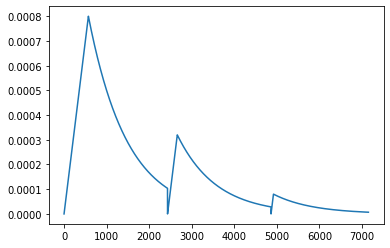

In [51]:
plt.rcParams['figure.facecolor'] = 'white'
plt.plot([clr(tf.convert_to_tensor(i)) for i in range(0,100*steps_per_epoch,2)])

In [52]:
# clr = CustomCLR(
#         offset=clr_offset,
#         initial_learning_rate=CONFIG["min_lr"],
#         maximal_learning_rate=CONFIG["max_lr"],
#         step_size=clr_step,
#         scale_mode="cycle")

# wdc = CustomCLR(
#         offset=clr_offset,
#         initial_learning_rate=CONFIG["weight_decay"]*CONFIG["min_lr"]/CONFIG["max_lr"],
#         maximal_learning_rate=CONFIG["weight_decay"],
#         step_size=clr_step,
#         scale_mode="cycle")

In [53]:
if CONFIG["optimizer"] == 'adamw':
    opt = tfa.optimizers.AdamW(learning_rate=clr, weight_decay=wdc)
elif CONFIG["optimizer"] == 'adam':            # or just make weight_decay=0
    opt = tf.keras.optimizers.Adam(learning_rate=clr)
opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

In [54]:
if CONFIG["loss_function"] == 'FocalTversky':
    loss_function = FocalTversky()
elif CONFIG["loss_function"] == 'cce':
    loss_function = cce

In [55]:
model.compile(optimizer=opt, loss=loss_function, metrics=[dsc])

In [56]:
model.save(wandb.run.dir+"/model-latest.h5")

In [57]:
wandb.save("*.h5")

['/content/3D_res_attn_Unet/wandb/run-20210620_171039-3fo3nzzb/files/model-latest.h5']

In [58]:
# # VERIFY LATEST OR BEST
# model = tf.keras.models.load_model(wandb.restore("model-latest.h5").name, custom_objects={'ConvNorm': ConvNorm,
#                                                                                           'NormAct': NormAct,
#                                                                                           'AttnBottleneckBlock': AttnBottleneckBlock,
#                                                                                           'BasicBlock': BasicBlock,
#                                                                                           'InvertedResBlock': InvertedResBlock,
#                                                                                           'SqueezeExcite': SqueezeExcite,
#                                                                                           'MHSA3D': MHSA3D,
#                                                                                           'AbsPosEmb': AbsPosEmb,
#                                                                                           'dsc': dsc,
#                                                                                           'FocalTversky': FocalTversky,
#                                                                                           'CustomCLR': CustomCLR,
#                                                                                           'WarmupExponentialDecay': WarmupExponentialDecay,
#                                                                                           'WarmupExponentialDecayRestarts': WarmupExponentialDecayRestarts
#                                                                                           })
# model.compile(optimizer=model.optimizer, loss=model.loss, metrics=[dsc])

In [64]:
wandb_cb = WandbCallback(monitor='dsc', mode='max')

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        img, lbl = next(iter(val_ds))
        pred = self.model(img)
        if epoch % BATCH_SIZE:
            i = np.random.randint(0,BATCH_SIZE)
            img = img[i,1].numpy()
            mn = img.min()
            mx = img.max()
            img = (img - mn)/(mx - mn) * 255
            lbl = lbl[i,1:].numpy()*255
            pred = pred[i,1:].numpy()*255
            get_gif(img, lbl, pred, "out.gif")
            wandb.log({"Outputs": wandb.Image("out.gif")}),
        wandb.log({"lr": self.model.optimizer.inner_optimizer._decayed_lr('float32').numpy()})
        self.model.save(wandb.run.dir+"/model-latest.h5")
        wandb.save("*.h5")                      # For forcing sync
        gc.collect()

In [65]:
initial_epoch = int(tf.round(model.optimizer.iterations/steps_per_epoch))
initial_epoch

0

In [ ]:
history = model.fit(train_ds,
                    epochs=100,
                    steps_per_epoch=np.ceil(len(train_paths)/BATCH_SIZE),
                    validation_data=val_ds,
                    validation_steps=np.ceil(len(val_paths)//BATCH_SIZE),
                    initial_epoch=initial_epoch,
                    workers=3,
                    callbacks=[CustomCallback(), wandb_cb])

Epoch 1/100
143/143 [==============================] - 493s 3s/step - loss: 3.2164 - dsc: 0.0408 - val_loss: 2.9027 - val_dsc: 0.1006
Epoch 2/100
143/143 [==============================] - 447s 3s/step - loss: 2.4260 - dsc: 0.2570 - val_loss: 1.8348 - val_dsc: 0.4809
Epoch 3/100
 94/143 [==================>...........] - ETA: 2:13 - loss: 1.9399 - dsc: 0.4257

In [ ]:
model.save(wandb.run.dir+"/model-latest.h5")

In [ ]:
model.evaluate(val_ds, steps=np.ceil(len(val_paths)//BATCH_SIZE))

In [ ]:
scores = []
for i, (a,b) in tqdm(enumerate(train_ds)):
    if i==steps_per_epoch:
        break
    o = model(a)
    o = tf.cast(o, tf.float32)
    scores.append(dsc(b,o))

In [ ]:
np.mean(scores, axis=0)

In [ ]:
run.finish()